# Livrable 1 : Classification Binaire
|Erwan Martin|Thibaut Liger-Hellard|Arnaud Maturel|Guillaume Le Cocguen|Victorien Goudeau|
|------------|---------------------|--------------|--------------------|-----------------|

**Contexte**:
L'objectif de ce livrable est classifier les photos des "non-photos" parmis les images du dataset.
La classification sera donc binaire.


# import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL

import os

import sklearn
import tensorflow as tf
import tensorboard


In [2]:
#verify GPU available (not mendatory)
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Préparation des données
Afin de faire la classification binaire des images il va falloir préparer nos données en étiquettant nos images et en les mettant a la même échelle (scaling).

In [3]:
#data path definition
f = open('../data/path.txt', "r")
DATAPATH = f.read()
print(DATAPATH)

D:\CESI\A5\datascience\Projet\data


In [4]:
# dataset creation
labels = []
imgs = []

#creating labels table -----------------------------
for i in os.listdir(path=DATAPATH):
    if os.path.isdir(DATAPATH+"/"+i):
        labels.append(i)
#end creating labels table -----------------------------

#removing livrable2  from dataset------------------------
labels.remove("Dataset_L2")
labels.remove("Photo_2")
#end removing livrable2 from dataset------------------------


print(f"LABELS : {labels}")

#create BIG csv with image path + label
csv = open("../data/dataset_L1.csv", "w")
csv.write("pathname;label\n")
for label in labels:
    if label == "Photo":
        l = 1
    else:
        l=0
    for img in os.listdir(path=DATAPATH+"/"+label):
        csv.write(DATAPATH+"/"+label+"/"+img+";"+str(l)+"\n")
csv.close()

LABELS : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


maintenant, il faut le load dans un pandas, regardons ce que ca donne:

In [5]:
data = pd.read_csv("../data/dataset_L1.csv", sep=';')
data.head()

,pathname,label
0,D:\CESI\A5\datascience\Projet\data/Painting/pa...,0
1,D:\CESI\A5\datascience\Projet\data/Painting/pa...,0
2,D:\CESI\A5\datascience\Projet\data/Painting/pa...,0
3,D:\CESI\A5\datascience\Projet\data/Painting/pa...,0
4,D:\CESI\A5\datascience\Projet\data/Painting/pa...,0


D:\CESI\A5\datascience\Projet\data/Photo/photo_2921.jpg
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


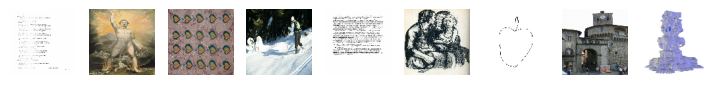

In [6]:
import sklearn.model_selection


img_height = 100
img_width = 100


def getImage(img_path, label):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [img_width, img_height])
    return image, label


train_df, test_df = sklearn.model_selection.train_test_split(data, test_size=0.3, shuffle=True, random_state=42)


print(train_df.iloc[70]["pathname"])

train_set = tf.data.Dataset.from_tensor_slices((train_df["pathname"].values, train_df["label"].values)).map(getImage,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(10)
test_set = tf.data.Dataset.from_tensor_slices((test_df["pathname"].values, test_df["label"].values)).map(getImage,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(10)



print(train_set)

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.subplot(1,10,i+1)
        plt.imshow(images[i]/255, cmap=plt.cm.binary)
        plt.axis("off")


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# CNN

In [7]:
num_classes = 2 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche

model = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(15, (5,5), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(30, (3,3), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')]
)

model.compile(optimizer =  'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.build((None, img_height, img_width, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 15)      1140      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 15)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 30)        4080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 30)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 18750)             0

# Training

In [8]:
epochs=10
history =  model.fit(train_set, validation_data=test_set, epochs=epochs)

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

Epoch 1/10


d:\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 221/2898 [=>............................] - ETA: 21s - loss: 0.4382 - accuracy: 0.7719

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_971]